In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import scipy.sparse as sp


import subprocess
import json
import tempfile
from transformers import RobertaTokenizer

from collections import defaultdict

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score
)
from tqdm import tqdm

device = torch.device("cpu")

In [2]:
def drop_node(feats, drop_rate,training=True,seed=42):
    """
    Args:
        feats (Tensor): 节点特征 [batch_size, num_nodes, feature_dim] 或 [num_nodes, feature_dim]
        drop_rate (float): 丢弃概率。

    Returns:
        Tensor: 丢弃后的节点特征，与输入形状一致。
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if not training or drop_rate <= 0.0:
        return feats
    if feats.dim() == 2:  # [num_nodes, feature_dim]
        num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((num_nodes,), drop_rate, device=feats.device, dtype=feats.dtype)  # [num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(1).expand(-1, feature_dim)  # [num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    elif feats.dim() == 3:  # [batch_size, num_nodes, feature_dim]
        batch_size, num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((batch_size, num_nodes), drop_rate, device=feats.device, dtype=feats.dtype)  # [batch_size, num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(2).expand(-1, -1, feature_dim)  # [batch_size, num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    else:
        raise ValueError(f"Unsupported feats dimension: {feats.dim()}")

    return feats


class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, input_dropout, hidden_dropout, batchnorm):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(in_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, out_dim)
        self.input_dropout = nn.Dropout(input_dropout)
        self.hidden_dropout = nn.Dropout(hidden_dropout)
        self.bn1 = nn.BatchNorm1d(in_dim) if batchnorm else None
        self.bn2 = nn.BatchNorm1d(hid_dim) if batchnorm else None

    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()

    def forward(self, x):
        if self.bn1:
            x = self.bn1(x)
        x = self.input_dropout(x)
        x = F.relu(self.layer1(x))
        if self.bn2:
            x = self.bn2(x)
        x = self.hidden_dropout(x)
        x = self.layer2(x)
        return x






class GGGNN(nn.Module):
    def __init__(self, feature_dim_size, hidden_size, num_GNN_layers, dropout, act=nn.functional.relu):
        super(GGGNN, self).__init__()
        self.num_GNN_layers = num_GNN_layers
        self.emb_encode = nn.Linear(feature_dim_size, hidden_size)
        self.dropout_encode = nn.Dropout(dropout)
        self.z0 = nn.Linear(hidden_size, hidden_size)
        self.z1 = nn.Linear(hidden_size, hidden_size)
        self.r0 = nn.Linear(hidden_size, hidden_size)
        self.r1 = nn.Linear(hidden_size, hidden_size)
        self.h0 = nn.Linear(hidden_size, hidden_size)
        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.soft_att = nn.Linear(hidden_size, 1)
        self.ln = nn.Linear(hidden_size, hidden_size)
        self.act = act

    def gatedGNN(self, x, adj):
        a = torch.matmul(adj, x)
        # update gate
        z0 = self.z0(a)
        z1 = self.z1(x)
        z = torch.sigmoid(z0 + z1)
        # reset gate
        r = torch.sigmoid(self.r0(a) + self.r1(x))
        # update embeddings
        h = self.act(self.h0(a) + self.h1(r * x))

        return h * z + x * (1 - z)

    def forward(self, inputs, adj, mask):        # mask [B, N]
        x = self.dropout_encode(inputs)
        x = self.emb_encode(x)          # [B, N, H]
        mask_3d = mask.unsqueeze(-1)             # [B, N, 1]

        x = x * mask_3d                          # 广播到 [B, N, H]
        for _ in range(self.num_GNN_layers):
            x = self.gatedGNN(x, adj) * mask_3d  # 避免重复 unsqueeze
        return x

In [3]:
class GRAND_GatedFusion(nn.Module):
    def __init__(self,
                 in_dim,
                 hid_dim,
                 S=5,
                 K=3,
                 num_GNN_layers=2,
                 node_dropout=0.05,
                 input_droprate=0.1,
                 hidden_droprate=0.1,
                 batchnorm=False,
                 att_op='sum',
                 num_heads=8,
                 temp=0.5,
                 lam=1.0,
                 gnn_dropout=0.1,
                 args=None):
        super(GRAND_GatedFusion, self).__init__()
        self.S = S
        self.K = K
        self.args = args
        self.node_dropout_rate = node_dropout
        self.att_op = att_op
        self.temp = temp
        self.lam = lam
        
        # GRAND components
        self.grand_mlp = MLP(in_dim, hid_dim, hid_dim, input_droprate, hidden_droprate, batchnorm)
        
        # Gated GNN components
        self.gggnn = GGGNN(in_dim, hid_dim, num_GNN_layers, gnn_dropout)
        
        # Fusion gate parameters
        self.fusion_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.reset_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.update_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.output_gate = nn.Linear(2 * hid_dim, hid_dim)
        
        # Output layer parameters
        if self.att_op == 'atten':
            self.att_fc = nn.Linear(hid_dim, 1)
            self.out_dim = hid_dim
        elif self.att_op == 'mul_head':
            self.att_fc = nn.Linear(hid_dim, num_heads)
            self.out_dim = hid_dim * num_heads
        elif self.att_op == 'concat':
            self.out_dim = 2 * hid_dim
        else:
            self.out_dim = hid_dim



    
    def normalize_adj(self, adj):
        if adj.dim() == 3:            # batched dense
            eye = torch.eye(adj.size(-1), device=adj.device)
            adj = adj + eye           # 加自环
            deg = adj.sum(-1)         # [B,N]
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)   # 避免除零
            # 利用广播而不是显式 diag，加速
            return deg_inv_sqrt.unsqueeze(-1) * adj * deg_inv_sqrt.unsqueeze(-2)


        elif adj.dim() == 2:
            N = adj.size(0)
            eye = torch.eye(N, device=adj.device, dtype=adj.dtype)
            adj = adj + eye
            deg = adj.sum(dim=1)                      
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)    
            return deg_inv_sqrt.unsqueeze(1) * adj * deg_inv_sqrt.unsqueeze(0)


        else:
            raise ValueError(f"Unsupported adj dimension: {adj.dim()}")

    def grand_conv(self, X, adj_norm):
        X_agg = X.clone()
        for _ in range(self.K):
            X = adj_norm @ X
            X_agg += X
        return X_agg / (self.K + 1)

    def gate_fusion(self, grand_feats, ggnn_feats):
        """Gated fusion mechanism combining GRAND and Gated GNN features"""
        combined = torch.cat([grand_feats, ggnn_feats], dim=-1)
        
        # Gating mechanisms
        reset = torch.sigmoid(self.reset_gate(combined))
        update = torch.sigmoid(self.update_gate(combined))
        
        # Intermediate fusion state
        intermediate = torch.tanh(self.fusion_gate(torch.cat([grand_feats, reset * ggnn_feats], dim=-1)))
        
        # Final fused output
        fused_output = update * ggnn_feats + (1 - update) * intermediate
        
        # Output gate
        output_gate = torch.sigmoid(self.output_gate(combined))
        return output_gate * fused_output + (1 - output_gate) * grand_feats

    def aggregate(self, x, mask=None):
        """Aggregate node features into graph-level embeddings"""
        x_sum = torch.sum(x, dim=1, keepdim=True)
        x_max = torch.amax(x, dim=1, keepdim=True)
        x_mean = torch.mean(x, dim=1, keepdim=True)
        
        if self.att_op == 'sum':
            return (x_sum + x_max).squeeze(1)
        elif self.att_op == 'max+mean':
            return (x_mean + x_max).squeeze(1)
        elif self.att_op == 'concat':
            return torch.cat((x_sum, x_max), dim=2).squeeze(1)
        elif self.att_op == 'atten':            # 单头注意力
            scores = self.att_fc(x).squeeze(-1)         # [B, N]
            if mask is not None:
                scores = scores.masked_fill(mask == 0, -1e9)
            alpha = torch.softmax(scores, dim=1).unsqueeze(-1)
            return (alpha * x).sum(dim=1)
        elif self.att_op == 'mul_head':         # 多头注意力
            scores = self.att_fc(x)                       # [B, N, H]
            if mask is not None:
                scores = scores.masked_fill(mask.unsqueeze(-1) == 0, -1e9)  
            alpha = torch.softmax(scores, dim=1)
            z_heads = (alpha.unsqueeze(-1) * x.unsqueeze(2)).sum(dim=1)
            return z_heads.reshape(x.size(0), -1)
        else:
            # multiply
            return (x_sum * x_max).squeeze(1)

    def forward(self, inputs, adj, mask=None, seed=None):
        inputs = inputs
        adj = adj
        mask = mask if mask is not None else None
        
        # Precompute Gated GNN features (only once)
        ggnn_feats = self.gggnn(inputs, adj, mask) if mask is not None else self.gggnn(inputs, adj, torch.ones_like(inputs[:, :, 0]))
        
        if self.training:
            emb_list = [] 
            enhanced_outputs = []
            adj_norm = self.normalize_adj(adj)
            
            for i in range(self.S):
                # GRAND feature propagation with node dropout
                grand_inputs = drop_node(inputs, self.node_dropout_rate, True, seed=int(int(seed)*10+i))
                grand_prop = torch.stack([self.grand_conv(grand_inputs[b], adj_norm[b]) for b in range(grand_inputs.size(0))])
                
                # Pass through GRAND's MLP
                grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
                grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
                
                # Gated fusion of GRAND and Gated GNN features
                fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
                
                # Apply mask if provided
                if mask is not None:
                    fused_feats = fused_feats * mask.unsqueeze(-1)
                
                # Aggregate to graph-level
                graph_emb = self.aggregate(fused_feats, mask)
                emb_list.append(graph_emb) 
                enhanced_outputs.append(graph_emb)
            
            # Compute consistency loss
            # ps = [torch.softmax(output, dim=-1) for output in enhanced_outputs]
            # avg_p = torch.mean(torch.stack(ps, dim=0), dim=0)
            # sharp_p = (torch.pow(avg_p, 1./self.temp) / 
            #           torch.sum(torch.pow(avg_p, 1./self.temp), dim=-1, keepdim=True)).detach()
            
            # consistency_loss = sum(torch.mean((p - sharp_p).pow(2).sum(dim=-1)) for p in ps) / len(ps)
            
            # Return mean graph embedding and consistency loss
            # return torch.mean(torch.stack(enhanced_outputs, dim=0), dim=0), consistency_loss

            return torch.stack(emb_list, dim=0), None
        
        
        else:  # Inference mode
            # GRAND feature propagation without dropout
            adj_norm = self.normalize_adj(adj)
            grand_prop = torch.stack([self.grand_conv(inputs[b], adj_norm[b]) for b in range(inputs.size(0))])
            
            # Pass through GRAND's MLP
            grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
            grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
            
            # Gated fusion
            fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
            
            # Apply mask if provided
            if mask is not None:
                fused_feats = fused_feats * mask.unsqueeze(-1)
            
            # Aggregate to graph-level
            graph_emb = self.aggregate(fused_feats, mask)
            return graph_emb, None


In [4]:
import torch.nn as nn, torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, base_cfg, num_classes):
        super().__init__()
        self.encoder = GRAND_GatedFusion(**base_cfg).float()
        self.classifier = nn.Linear(self.encoder.out_dim, num_classes)
        # self.classifier = nn.Linear(base_cfg['hid_dim']*base_cfg['num_heads'],  # out_dim
        #                             num_classes)

    def forward(self, x, adj, mask, seed=None, train_consistency=True):
        if self.training and train_consistency:
            # ---------- (1) 取 [S, B, D] ----------
            emb_stack, _ = self.encoder(x, adj, mask, seed=seed)

            # ---------- (2) 得到 [S, B, C] ----------
            logits_stack = self.classifier(emb_stack)

            # ---------- (3) 计算 Sharpen consistency ----------
            ps = torch.softmax(logits_stack, dim=-1)       # [S,B,C]
            avg_p = ps.mean(dim=0)                         # [B,C]

            temp = self.encoder.temp                       # 与 cfg 保持一致
            sharp_p = (avg_p.pow(1. / temp) /
                    avg_p.pow(1. / temp).sum(dim=-1, keepdim=True)).detach()

            consistency = ((ps - sharp_p) ** 2).sum(-1).mean()

            # ---------- (4) 把 S 个 logits 取平均做分类 ----------
            logits = logits_stack.mean(dim=0)              # [B,C]

        else:                                              # Eval 或关闭一致性
            emb, _ = self.encoder(x, adj, mask)
            logits = self.classifier(emb)
            consistency = torch.tensor(0., device=logits.device)

        return logits, consistency


In [5]:

import json, re, os, random

from dataclasses import dataclass
from typing import List
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import (RobertaForSequenceClassification, AutoTokenizer)
# Jupyter Cell 2
def clean_code(code: str) -> str:
    """去单/多行注释 + 空行"""
    code = re.sub(r"//.*?$",     "", code, flags=re.MULTILINE)
    code = re.sub(r"/\*.*?\*/",  "", code, flags=re.DOTALL)
    code = re.sub(r"^\s*$\n?",   "", code, flags=re.MULTILINE)
    return code.strip()

@dataclass
class InputFeatures:
    input_ids:  List[int]
    attention_mask: List[int]
    label: int

def convert_example(js, tokenizer, block_size):
    code = ' '.join(clean_code(js['functionSource']).split())
    tokens = tokenizer.tokenize(code)[: block_size - 2]
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    attn_mask = [1] * len(input_ids)

    pad_len = block_size - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * pad_len
    attn_mask += [0] * pad_len

    return InputFeatures(
        input_ids      = input_ids,
        attention_mask = attn_mask,
        label          = int(js['label'])
    )
%env http_proxy=http://10.254.25.18:7890
%env https_proxy=http://10.254.25.18:7890

%env TOKENIZERS_PARALLELISM=false


env: http_proxy=http://10.254.25.18:7890
env: https_proxy=http://10.254.25.18:7890
env: TOKENIZERS_PARALLELISM=false


In [6]:



att_op_dict = {
    'sum': 'sum',
    'mul': 'mul',
    'concat': 'concat'
}



weighted_graph = False
print('using default unweighted graph')

TF_IDF = True
PMI =True

from transformers import RobertaTokenizer  # 确保导入tokenizer
tokenizer = RobertaTokenizer.from_pretrained('microsoft/graphcodebert-base')
from collections import Counter

def collect_global_stats(shuffle_doc_words_list, window_size=3):
    token_freq  = Counter()      # P(w)
    pair_freq   = Counter()      # P(w_i, w_j) 共现
    total_windows = 0

    for doc in shuffle_doc_words_list:
        end = len(doc)
        while end > 0 and doc[end-1] in {1, 2}:
            end -= 1
        doc = doc[:end]

        # 更新 token 出现次数
        token_freq.update(doc)

        # 遍历窗口统计共现
        if len(doc) <= window_size:
            windows = [doc]
        else:
            windows = [doc[i:i+window_size] for i in range(len(doc)-window_size+1)]

        for win in windows:
            total_windows += 1
            for i in range(1, len(win)):
                for j in range(0, i):
                    u, v = win[i], win[j]
                    if u == v: 
                        continue
                    pair_freq[(u, v)] += 1
                    pair_freq[(v, u)] += 1   # 无向
    return token_freq, pair_freq, total_windows






def build_graph(shuffle_doc_words_list, word_embeddings, window_size=3, weighted_graph=True,TF_IDF=False, PMI=False):
    if TF_IDF:
        token_freq, pair_freq, W = collect_global_stats(shuffle_doc_words_list, window_size=window_size)
        def pmi(u, v, W, eps=1e-9):
            # 频数 → 概率
            p_uv = pair_freq[(u, v)] / W
            p_u  = token_freq[u] / W
            p_v  = token_freq[v] / W
            val = np.log((p_uv + eps) / (p_u * p_v + eps))
            return max(val, 0.)          # 常见做法：负 PMI 设 0（稀疏化）
        

    x_adj = []
    x_feature = []
    doc_len_list = []
    vocab_set = set()

    # 确保 word_embeddings 是 NumPy 数组
    if isinstance(word_embeddings, torch.Tensor):
        embeddings_np = word_embeddings.cpu().numpy()
    else:
        embeddings_np = word_embeddings

    for i in range(len(shuffle_doc_words_list)):
        doc_words = shuffle_doc_words_list[i]
        end = len(doc_words)
        while end > 0 and doc_words[end-1] in {1, 2}:  # 移除padding
            end -= 1
        doc_words = doc_words[:end]
        doc_len = len(doc_words)

        # 获取token字符串表示
        tokens_str = tokenizer.convert_ids_to_tokens(doc_words)
        
        doc_vocab = list(set(doc_words))
        doc_nodes = len(doc_vocab)

        doc_len_list.append(doc_nodes)
        vocab_set.update(doc_vocab)

        doc_word_id_map = {}
        for j in range(doc_nodes):
            doc_word_id_map[doc_vocab[j]] = j

        # 使用defaultdict简化边计数
        word_pair_count = defaultdict(float)

        # 1. 添加滑动窗口共现边
        windows = []
        if doc_len <= window_size:
            windows.append(doc_words)
        else:
            for j in range(doc_len - window_size + 1):
                window = doc_words[j: j + window_size]
                windows.append(window)

        for window in windows:
            for p in range(1, len(window)):
                for q in range(0, p):
                    word_p_id = window[p]
                    word_q_id = window[q]
                    if word_p_id == word_q_id:
                        continue
                    # 共现边（双向添加）
                    word_pair_count[(word_p_id, word_q_id)] += 1.0
                    word_pair_count[(word_q_id, word_p_id)] += 1.0

        # 2. 添加基本的数据流边（基于常见代码模式）
        for pos in range(1, doc_len):
            current_token = doc_words[pos]
            prev_token = doc_words[pos-1]
            current_token_str = tokens_str[pos]
            
            # 模式1: 赋值语句 (a = b)
            # 处理带空格的等号 (Ġ=) 和普通等号 (=)
            if current_token_str in ["=", "Ġ="] and pos > 0 and pos < doc_len - 1:
                # 连接左侧变量和右侧表达式
                if pos >= 1 and pos < doc_len - 1:
                    left_var = doc_words[pos-1]
                    right_expr = doc_words[pos+1]
                    word_pair_count[(left_var, right_expr)] += 2.0
                    word_pair_count[(right_expr, left_var)] += 2.0
            
            # 模式2: 方法调用 (obj.method())
            # 处理带空格的点 (Ġ.) 和普通点 (.)
            if current_token_str in [".", "Ġ."] and pos > 0 and pos < doc_len - 1:
                # 连接对象和方法名
                if pos >= 1 and pos < doc_len - 1:
                    obj = doc_words[pos-1]
                    method = doc_words[pos+1]
                    word_pair_count[(obj, method)] += 1.5
                    word_pair_count[(method, obj)] += 1.5
            
            # 模式3: 函数参数 (func(a, b))
            # 处理带空格的开括号 (Ġ() 和普通开括号 (()
            if current_token_str in ["(", "Ġ("] and pos > 0:
                # 连接函数名和参数
                func_name = doc_words[pos-1]
                # 添加函数名到下一个token的边
                if pos < doc_len - 1:
                    first_param = doc_words[pos+1]
                    word_pair_count[(func_name, first_param)] += 1.2
                    word_pair_count[(first_param, func_name)] += 1.2
                # 添加函数名到所有后续参数
                param_pos = pos + 1
                # 处理带空格的闭括号 (Ġ)) 和普通闭括号 ())
                while param_pos < doc_len and tokens_str[param_pos] not in [")", "Ġ)"]:
                    if tokens_str[param_pos] not in [",", "Ġ,", ";", "Ġ;"]:
                        param_token = doc_words[param_pos]
                        word_pair_count[(func_name, param_token)] += 0.8
                        word_pair_count[(param_token, func_name)] += 0.8
                    param_pos += 1
            
            # 模式4: 返回值 (return x)
            # 检查带空格的return (Ġreturn) 和普通return (return)
            if tokens_str[pos-1] in ["return", "Ġreturn"] and pos > 1:
                return_value = current_token
                word_pair_count[(prev_token, return_value)] += 1.3
                word_pair_count[(return_value, prev_token)] += 1.3

        # 3. 添加子词连接边（处理长变量名）
        current_var_tokens = []  # 当前变量名的token序列
        
        for pos in range(doc_len):
            token_id = doc_words[pos]
            token_str = tokens_str[pos]
            
            # 检查是否是变量名的开始或延续
            if token_str.startswith("Ġ") or not current_var_tokens:
                # 新token开始（以空格开头或当前序列为空）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        # 添加强连接（双向）
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                
                # 重置当前变量名（跳过特殊token和运算符）
                # 只将标识符加入变量名序列
                if token_str not in ["[CLS]", "[SEP]", "[PAD]", "(", ")", "{", "}", "=", ".", ",", ";"] \
                   and not token_str.startswith("Ġ(") \
                   and not token_str.startswith("Ġ)") \
                   and not token_str.startswith("Ġ{") \
                   and not token_str.startswith("Ġ}") \
                   and not token_str.startswith("Ġ=") \
                   and not token_str.startswith("Ġ.") \
                   and not token_str.startswith("Ġ,") \
                   and not token_str.startswith("Ġ;"):
                    current_var_tokens = [token_id]
                else:
                    current_var_tokens = []
            elif token_str.startswith("##") or token_str.isalnum() or '_' in token_str:
                # 变量名延续（子词token或标识符）
                current_var_tokens.append(token_id)
            else:
                # 其他token（标点、关键字等）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                current_var_tokens = []
        
        # 处理文档末尾的变量名
        if current_var_tokens:
            for idx in range(1, len(current_var_tokens)):
                prev_id = current_var_tokens[idx-1]
                curr_id = current_var_tokens[idx]
                
                word_pair_count[(prev_id, curr_id)] += 3.0
                word_pair_count[(curr_id, prev_id)] += 3.0

        # 构建邻接矩阵
        row, col, weight = [], [], []
        for (u, v), w in word_pair_count.items():
            if u in doc_word_id_map and v in doc_word_id_map:
                row.append(doc_word_id_map[u])
                col.append(doc_word_id_map[v])
                if TF_IDF:
                    weight.append(pmi(u, v, W))
                else:
                    weight.append(w if weighted_graph else 1.0)
        
        adj = sp.csr_matrix((weight, (row, col)), shape=(doc_nodes, doc_nodes))
        x_adj.append(adj)

        # 构建节点特征
        features = []
        for word_id in doc_vocab:
            # 确保 word_id 是整数
            word_id = int(word_id)
            
            # 检查索引是否在嵌入矩阵范围内
            if word_id < embeddings_np.shape[0]:
                features.append(embeddings_np[word_id])
            else:
                # 处理超出范围的索引 - 使用零向量
                features.append(np.zeros(embeddings_np.shape[1]))
        
        x_feature.append(features)

    return x_adj, x_feature

class JsonlCodeDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=512, sample_percent=1.0):
        self.features = []
        with open(file_path) as f:
            total = sum(1 for _ in f)
        with open(file_path) as f:
            for line in tqdm(f, total=total, desc="Building dataset"):
                js = json.loads(line)
                feat = convert_example(js, tokenizer, block_size)
                self.features.append(feat)

        # 采样（可选）
        if 0 < sample_percent < 1.0:
            random.seed(42)
            random.shuffle(self.features)
            keep_num = int(sample_percent * len(self.features))
            self.features = self.features[:keep_num]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feat = self.features[idx]
        return (
            torch.tensor(feat.input_ids,      dtype=torch.long),
            torch.tensor(feat.attention_mask, dtype=torch.long),
            torch.tensor(feat.label,          dtype=torch.long),
        )
    
model = RobertaForSequenceClassification.from_pretrained('microsoft/graphcodebert-base')
w_embeddings = model.get_input_embeddings().weight.data.cpu().detach().clone().numpy()
def collate_graph(batch, window_size=3):
    """
    batch 由 Dataset 返回的:
        input_ids, attn_mask, label
    本函数在 CPU 上:
        1) 转成 numpy list
        2) 调 build_graph
        3) 把 scipy csr 转成 PyG/DGL 或留作训练时再转
    """
    ids, masks, labels = zip(*batch)                 # tuple of Tensor
    ids_np  = [x.numpy() for x in ids]               # 每条句子 token-id list
    labels  = torch.stack(labels)                    # Tensor [B]

    # --- 调你的 graph 构造 ---
    x_adj, x_feat = build_graph(
        shuffle_doc_words_list = ids_np,
        word_embeddings        = w_embeddings,
        window_size            = window_size,
        weighted_graph         = True,
        TF_IDF                 = True
    )

    return {
        "input_ids" : torch.stack(ids),              # [B, L]
        "attention_mask": torch.stack(masks),        # [B, L]
        "labels": labels,                            # [B]
        "adjs":  x_adj,                              # list
        "feats": x_feat                              # list
    }


using default unweighted graph


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import os, random, numpy as np, torch
seed_number=42
def set_global_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)        # Python 层哈希随机
    random.seed(seed)                               # 内置 random
    np.random.seed(seed)                            # numpy
    torch.manual_seed(seed)                         # CPU
    torch.cuda.manual_seed(seed)                    # 当前 GPU
    torch.cuda.manual_seed_all(seed)                # 所有 GPU

    # 额外：在部分算子中强制使用确定性实现
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False          # 禁止自动算法搜索
    torch.use_deterministic_algorithms(True)        # ≥1.8，捕获非确定性算子

    # CUDA ≥ 10.2：卷积类算子还需要这个环境变量
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

set_global_seed(seed_number)

def seed_worker(worker_id):
    # 每个 worker 用不同 seed，但与主进程严格可重复
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_number)

In [8]:
# Jupyter Cell 4
# MODEL_NAME = "Salesforce/codet5-base"   # 或 graphcodebert-base
MODEL_NAME = 'microsoft/graphcodebert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

BLOCK_SIZE = 2048        # <— 最大输入长度
BATCH_SIZE = 128





def filter_by_len(dataset, max_len=512):
    filtered = []
    for feat in dataset.features:
        # 去掉 padding 后的真实长度
        real_len = sum(feat.attention_mask)
        if real_len < max_len:
            filtered.append(feat)
    dataset.features = filtered
    return dataset


train_ds = JsonlCodeDataset("dataset/reveal/train.jsonl", tokenizer, block_size=BLOCK_SIZE)
val_ds  = JsonlCodeDataset("dataset/reveal/valid.jsonl", tokenizer, block_size=BLOCK_SIZE)
test_ds  = JsonlCodeDataset("dataset/reveal/test.jsonl", tokenizer, block_size=BLOCK_SIZE)


train_loader = DataLoader(
    train_ds,
    sampler = RandomSampler(train_ds, generator=g), # generator 已锁定
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,
    num_workers = 32,
    pin_memory = True,
    persistent_workers=True,
    # prefetch_factor=4, 
    worker_init_fn = seed_worker                 # ★ 加这一行
)


val_loader = DataLoader(
    val_ds,
    sampler = RandomSampler(val_ds, replacement=False),
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,     # ⭐️ 重点
    num_workers = 8,
    pin_memory = True,
    persistent_workers=True,
    prefetch_factor=4, 
    worker_init_fn = seed_worker 
)


test_loader = DataLoader(
    test_ds,
    sampler = RandomSampler(test_ds, replacement=False),
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,     # ⭐️ 重点
    num_workers = 8,
    pin_memory = True,
    worker_init_fn = seed_worker 
)



# Building dataset:   0%|          | 0/18187 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1760 > 512). Running this sequence through the model will result in indexing errors
# Building dataset: 100%|██████████| 18187/18187 [00:36<00:00, 498.52it/s]
# Building dataset: 100%|██████████| 2273/2273 [00:04<00:00, 502.68it/s]
# Building dataset: 100%|██████████| 2274/2274 [00:05<00:00, 444.60it/s]

Building dataset: 100%|██████████| 2274/2274 [00:02<00:00, 863.04it/s] 
/home/yt/anaconda3/envs/openr/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
# ---- 工具函数：计算真实长度（去掉 padding）----
def real_len_from_mask(attn_mask):
    # attn_mask 是 0/1，sum 即为真实长度
    if torch.is_tensor(attn_mask):
        return int(attn_mask.sum().item())
    return int(sum(attn_mask))

# ---- 第一步：过滤掉 >8k 的样本（也可设下限 >=3）----
def filter_by_len(dataset, max_len=8192, min_len=3):
    filtered = []
    for feat in dataset.features:
        L = real_len_from_mask(feat.attention_mask)
        if min_len <= L <= max_len:
            filtered.append(feat)
    dataset.features = filtered
    return dataset

# ---- 第二步：把剩下样本统一截成 2k（包含 [CLS]/[SEP] 与 padding）----
def truncate_inplace(dataset, to_len=2048, pad_token_id=1):  # GCBERT: pad_token_id=1
    new_feats = []
    for feat in dataset.features:
        # 先根据 attn_mask 拿真实有效 token（含 [CLS] ... [SEP]）
        L = real_len_from_mask(feat.attention_mask)
        # 真实 token 截断到 to_len
        keep = min(L, to_len)
        input_ids = feat.input_ids[:keep]
        attn_mask = feat.attention_mask[:keep]

        # 末尾补 SEP：如果真实 token 里本就有 SEP 且被截走了，可加一个兜底
        # 注意：你的 convert_example 已经在末尾加了 [SEP]，这里通常不必另加
        # 仅在极端情况下（比如 L<2）需要修复，但我们上面的 min_len 已经保证 >=3

        # padding 到 to_len
        pad_needed = to_len - len(input_ids)
        if pad_needed > 0:
            input_ids = input_ids + [pad_token_id] * pad_needed
            attn_mask = attn_mask + [0] * pad_needed
        else:
            # 完全等长就不补
            pass

        # 回写
        feat.input_ids = input_ids
        feat.attention_mask = attn_mask
        # feat.label 保持不变
        new_feats.append(feat)

    dataset.features = new_feats
    return dataset
# 1) 先用较大的 block_size 读取全长（你已经这样做了）
test_ds = JsonlCodeDataset("dataset/reveal/test.jsonl", tokenizer, block_size=1024*8)

# 2) 过滤掉 >8k 的样本（也可设下限 >=3，避免太短的无效样本）
test_ds = filter_by_len(test_ds, max_len=8190, min_len=3)

# 3) 统一把剩余样本截成 2k（GraphCodeBERT 的 pad_token_id=1）
test_ds = truncate_inplace(test_ds, to_len=2048, pad_token_id=tokenizer.pad_token_id)

# 4) 之后再建 DataLoader（你的 collate_graph 会基于截后的 tokens 构图）
test_loader = DataLoader(
    test_ds,
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,
    num_workers = 8,
    pin_memory = True,
)


Building dataset: 100%|██████████| 2274/2274 [00:03<00:00, 726.07it/s]


In [9]:


import math, time, random

from torch.optim.lr_scheduler import CosineAnnealingLR

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

from sklearn.metrics import precision_recall_curve
import numpy as np

from torch.optim import AdamW

config = {
    'in_dim'       : 768,
    'hid_dim'      : 128,           
    'S'            : 5,
    'K'            : 2,
    'num_GNN_layers': 2,
    'node_dropout' : 0.2,
    'input_droprate': 0.3,
    'hidden_droprate': 0.3,
    'batchnorm'    : True,
    'att_op'       : 'mul_head',
    'num_heads'    : 6,
    'temp'         : 0.6,
    'lam'          : 1.4,          
    'gnn_dropout'  : 0.2,
}




num_classes = 2
lam = config['lam']

model_path= "best_model-reveal-test-redo-lookfenbu.pt"


# 1. 实例化网络（只一次）
net = Net(config, num_classes).to(device)



cls_weight = torch.tensor([1.0, 1.0], device=device)  
criterion_cls  = nn.CrossEntropyLoss(weight=cls_weight)

# 2. 绑定优化器 / 调度器

optimizer = AdamW(net.parameters(), lr=5e-4, weight_decay=1e-2)

scheduler = CosineAnnealingLR(optimizer, T_max=50)

# 3. 训练循环
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_f1, best_val_acc = 0.0, 0.0
best_state, patience, wait = None, 20, 0

epochs = 180


def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    total_ex, correct, loss_sum = 0, 0, 0.0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)
            prob_pos = torch.softmax(logits, dim=-1)[:, 1]   # 概率(正类)
            loss_sum += criterion_cls(logits, labels).item() * labels.size(0)
            all_probs.append(prob_pos.cpu())
            all_labels.append(labels.cpu())
    y_true = torch.cat(all_labels).numpy()
    y_score = torch.cat(all_probs).numpy()
    y_pred  = (y_score >= threshold).astype(int)

    acc  = (y_pred == y_true).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_score)
    except:
        auc = 0.0
    loss = loss_sum / len(y_true)
    return acc, loss, prec, rec, f1, auc

def find_best_threshold(model, dataloader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)
            all_probs.append(torch.softmax(logits, dim=-1)[:, 1].cpu())
            all_labels.append(labels.cpu())
    y_true  = torch.cat(all_labels).numpy()
    y_score = torch.cat(all_probs).numpy()
    P, R, T = precision_recall_curve(y_true, y_score)
    F1 = 2 * P * R / (P + R + 1e-12)
    # precision_recall_curve 返回的 T 比 P/R 少一个元素，做对齐：
    best_idx = int(np.nanargmax(F1))
    best_thr = T[max(best_idx - 1, 0)] if best_idx > 0 else 0.0
    return float(best_thr), float(F1[best_idx])





def batch_to_tensor(batch, device):
    """把 collate_graph 返回的 dict ⇢ (feat, adj, mask, label) 四张量"""
    # 节点特征
    feats_list = batch["feats"]
    adjs_list  = batch["adjs"]
    labels     = batch["labels"].to(device)

    N_max = max(a.shape[0] for a in adjs_list)
    dim   = len(feats_list[0][0])           # 768

    # 统一 Padding
    featb = torch.zeros(len(feats_list), N_max, dim,  dtype=torch.float32, device=device)
    adjb  = torch.zeros(len(adjs_list),  N_max, N_max, dtype=torch.float32, device=device)
    maskb = torch.zeros(len(adjs_list),  N_max,        dtype=torch.float32, device=device)

    for i, (adj, feat) in enumerate(zip(adjs_list, feats_list)):
        n = adj.shape[0]
        adjb [i, :n, :n] = torch.from_numpy(adj.toarray()).to(device)
        featb[i, :n, :]  = torch.from_numpy(np.asarray(feat)).to(device)
        maskb[i, :n]     = 1.

    return featb, adjb, maskb, labels



train_losses, val_losses = [], []
train_accs, val_accs = [], []

wait = 0
init_seed=42
epoch = 0
while True:
    epoch+=1

    # ===== Train =====
    net.train()
    tr_loss_sum, cons_loss_sum, tr_correct, tr_ex = 0.0, 0.0, 0, 0
    bar = tqdm(train_loader, desc=f"Train Ep{epoch:03d}", leave=False)

    for batch in bar:
        featb, adjb, maskb, labels = batch_to_tensor(batch, device)
        bs = labels.size(0)               
        optimizer.zero_grad()
        seed   = init_seed + epoch

        logits, cons = net(featb, adjb, maskb, seed=seed, train_consistency=True)

        cls_loss = criterion_cls(logits, labels)
        
        loss = cls_loss + lam * cons

        loss.backward()

        optimizer.step()

        
        tr_loss_sum += cls_loss.item() * bs
        cons_loss_sum += cons.item() * bs
        tr_correct  += (logits.argmax(1) == labels).sum().item()
        tr_ex       += bs
        bar.set_postfix(cls_loss=f"{cls_loss.item() / bs:.4f}", cons_loss=f"{cons.item() / bs:.4f}")

    scheduler.step()
    train_loss = tr_loss_sum / tr_ex
    train_cons_loss = cons_loss_sum / tr_ex
    train_acc  = tr_correct  / tr_ex


    # ===== Validate =====
    net.eval()
    val_loss_sum, val_correct, val_ex = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        bar = tqdm(val_loader, desc=f"Val Ep{epoch:03d}", leave=False)
        for batch in bar:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = net(featb, adjb, maskb, train_consistency=False)

            bs = labels.size(0)
            val_loss_sum += criterion_cls(logits, labels).item() * bs
            preds = logits.argmax(1)

            val_correct  += (preds == labels).sum().item()
            val_ex       += bs

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # 拼接所有 batch 结果
    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    best_thr, _ = find_best_threshold(net, val_loader)
    val_acc, val_loss, prec, rec, f1, auc = evaluate(net, val_loader, threshold=best_thr)


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # ===== Log =====

    tqdm.write(
        f"Epoch {epoch:03d} | "
        f"train_loss {train_loss:.4f} (cls) + {train_cons_loss:.4f} (cons)  "
        f"triain_acc {train_acc:.4f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"P {prec:.4f} R {rec:.4f} F1 {f1:.4f}"
    )

    # ===== Early-stopping =====

    improved = (f1 > best_val_f1 + 1e-6) or (abs(f1 - best_val_f1) <= 1e-6 and val_acc > best_val_acc)

    if improved:
        best_threshold = best_thr if improved else best_threshold
        best_val_f1 = f1
        best_val_acc = val_acc
        best_state   = net.state_dict()
        torch.save(net.state_dict(), model_path)
        wait = 0
        tqdm.write(f"💾 Saved new best ckpt: F1={best_val_f1:.4f}, acc={best_val_acc:.4f} @ epoch {epoch:03d}")
    else:
        wait += 1
        if wait >= patience:
            tqdm.write(f"Early stop at epoch {epoch} | best F1={best_val_f1:.4f}, best acc={best_val_acc:.4f}")
            break




Epoch 001 | train_loss 0.3211 (cls) + 0.0075 (cons)  triain_acc 0.8956 | val_loss 0.2707 acc 0.8742 | P 0.3582 R 0.4571 F1 0.4017
💾 Saved new best ckpt: F1=0.4017, acc=0.8742 @ epoch 001


Epoch 002 | train_loss 0.2729 (cls) + 0.0079 (cons)  triain_acc 0.9011 | val_loss 0.2566 acc 0.8544 | P 0.3236 R 0.5286 F1 0.4014


Epoch 003 | train_loss 0.2525 (cls) + 0.0086 (cons)  triain_acc 0.9038 | val_loss 0.2421 acc 0.8834 | P 0.3970 R 0.5048 F1 0.4444
💾 Saved new best ckpt: F1=0.4444, acc=0.8834 @ epoch 003


Epoch 004 | train_loss 0.2409 (cls) + 0.0092 (cons)  triain_acc 0.9070 | val_loss 0.2313 acc 0.9067 | P 0.4944 R 0.4238 F1 0.4564
💾 Saved new best ckpt: F1=0.4564, acc=0.9067 @ epoch 004


Epoch 005 | train_loss 0.2260 (cls) + 0.0099 (cons)  triain_acc 0.9108 | val_loss 0.2255 acc 0.8953 | P 0.4431 R 0.5190 F1 0.4781
💾 Saved new best ckpt: F1=0.4781, acc=0.8953 @ epoch 005


Epoch 006 | train_loss 0.2172 (cls) + 0.0105 (cons)  triain_acc 0.9141 | val_loss 0.2216 acc 0.9120 | P 0.5301 R 0.4190 F1 0.4681


Epoch 007 | train_loss 0.2080 (cls) + 0.0112 (cons)  triain_acc 0.9159 | val_loss 0.3176 acc 0.8619 | P 0.3354 R 0.5048 F1 0.4030


Epoch 008 | train_loss 0.2110 (cls) + 0.0120 (cons)  triain_acc 0.9143 | val_loss 0.2107 acc 0.9015 | P 0.4698 R 0.5190 F1 0.4932
💾 Saved new best ckpt: F1=0.4932, acc=0.9015 @ epoch 008


Epoch 009 | train_loss 0.1990 (cls) + 0.0120 (cons)  triain_acc 0.9177 | val_loss 0.2176 acc 0.9138 | P 0.5402 R 0.4476 F1 0.4896


Epoch 010 | train_loss 0.1892 (cls) + 0.0125 (cons)  triain_acc 0.9213 | val_loss 0.2153 acc 0.9023 | P 0.4739 R 0.5190 F1 0.4955
💾 Saved new best ckpt: F1=0.4955, acc=0.9023 @ epoch 010


Epoch 011 | train_loss 0.1848 (cls) + 0.0127 (cons)  triain_acc 0.9216 | val_loss 0.2077 acc 0.9186 | P 0.5806 R 0.4286 F1 0.4932


Epoch 012 | train_loss 0.1803 (cls) + 0.0128 (cons)  triain_acc 0.9224 | val_loss 0.2165 acc 0.9111 | P 0.5222 R 0.4476 F1 0.4821


Epoch 013 | train_loss 0.1744 (cls) + 0.0131 (cons)  triain_acc 0.9234 | val_loss 0.2280 acc 0.8979 | P 0.4545 R 0.5238 F1 0.4867


Epoch 014 | train_loss 0.1734 (cls) + 0.0135 (cons)  triain_acc 0.9258 | val_loss 0.2279 acc 0.9094 | P 0.5109 R 0.4476 F1 0.4772


Epoch 015 | train_loss 0.1663 (cls) + 0.0135 (cons)  triain_acc 0.9268 | val_loss 0.2315 acc 0.8909 | P 0.4312 R 0.5667 F1 0.4897


Epoch 016 | train_loss 0.1636 (cls) + 0.0139 (cons)  triain_acc 0.9271 | val_loss 0.2281 acc 0.9059 | P 0.4898 R 0.4571 F1 0.4729


Epoch 017 | train_loss 0.1597 (cls) + 0.0141 (cons)  triain_acc 0.9274 | val_loss 0.2332 acc 0.8852 | P 0.4118 R 0.5667 F1 0.4770


Epoch 018 | train_loss 0.1557 (cls) + 0.0143 (cons)  triain_acc 0.9297 | val_loss 0.2262 acc 0.9059 | P 0.4898 R 0.4571 F1 0.4729


Epoch 019 | train_loss 0.1543 (cls) + 0.0143 (cons)  triain_acc 0.9307 | val_loss 0.2270 acc 0.8931 | P 0.4353 R 0.5286 F1 0.4774


Epoch 020 | train_loss 0.1487 (cls) + 0.0147 (cons)  triain_acc 0.9305 | val_loss 0.2272 acc 0.8685 | P 0.3746 R 0.6333 F1 0.4708


Epoch 021 | train_loss 0.1439 (cls) + 0.0147 (cons)  triain_acc 0.9319 | val_loss 0.2502 acc 0.8658 | P 0.3691 R 0.6381 F1 0.4677


Epoch 022 | train_loss 0.1418 (cls) + 0.0148 (cons)  triain_acc 0.9339 | val_loss 0.2653 acc 0.8627 | P 0.3607 R 0.6286 F1 0.4583


Epoch 023 | train_loss 0.1412 (cls) + 0.0150 (cons)  triain_acc 0.9332 | val_loss 0.2589 acc 0.8737 | P 0.3808 R 0.5857 F1 0.4615


Epoch 024 | train_loss 0.1360 (cls) + 0.0153 (cons)  triain_acc 0.9329 | val_loss 0.2698 acc 0.8702 | P 0.3768 R 0.6190 F1 0.4685


Epoch 025 | train_loss 0.1339 (cls) + 0.0155 (cons)  triain_acc 0.9365 | val_loss 0.2354 acc 0.8733 | P 0.3892 R 0.6524 F1 0.4875


Epoch 026 | train_loss 0.1310 (cls) + 0.0157 (cons)  triain_acc 0.9367 | val_loss 0.2637 acc 0.8557 | P 0.3479 R 0.6429 F1 0.4515


KeyboardInterrupt: 

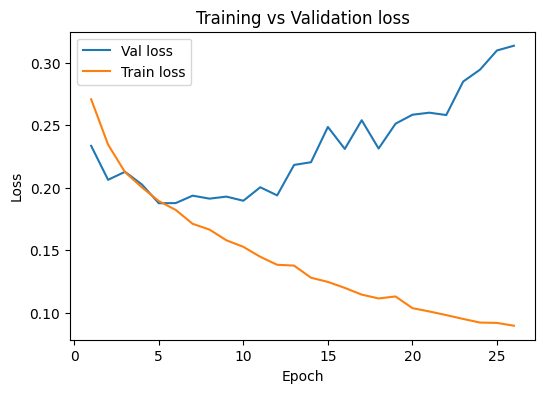

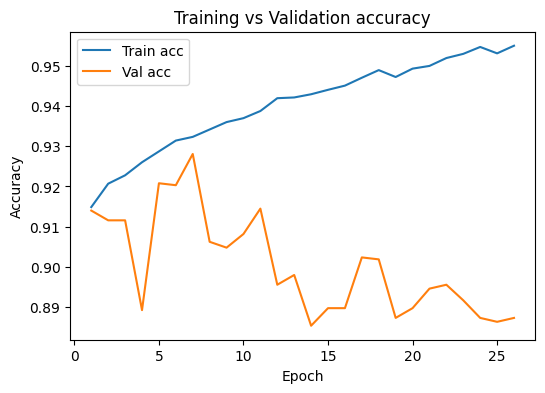

In [10]:
import matplotlib.pyplot as plt

epochs_r = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
def to_float(x):
    if torch.is_tensor(x):
        return x.detach().cpu().item()
    return float(x)

val_vals   = [to_float(v) for v in val_losses]
train_vals = [to_float(v) for v in train_losses]

plt.plot(epochs_r, val_vals,   label='Val loss')
plt.plot(epochs_r, train_vals, label='Train loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation loss')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_r, train_accs, label='Train acc')
plt.plot(epochs_r, val_accs,  label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation accuracy')
plt.show()


In [10]:
# === 重新实例化网络，与训练时配置保持一致 ===
best_net = Net(config, num_classes).to(device)

# === 加载参数 ===
best_net.load_state_dict(torch.load(model_path, map_location=device))

best_net.eval()      # 切到推理模式（BN/Dropout 会自动关闭）



def pretty_print(split_name, metrics):
    acc, loss, prec, rec, f1, auc= metrics
    print(
        f"{split_name:<5} | "
        f"loss {loss:8.4f} | "
        f"acc {acc:6.4f} | "
        f"P {prec:6.4f} | "
        f"R {rec:6.4f} | "
        f"F1 {f1:6.4f}| "
        f"AUC {auc:6.4f}"
    )


# 评估
val_metrics  = evaluate(best_net, val_loader, threshold=best_threshold)
test_metrics = evaluate(best_net, test_loader, threshold=best_threshold)

# 打印
print("="*55)
pretty_print("VAL",  val_metrics)
pretty_print("TEST", test_metrics)
print("="*55)
# =======================================================
# VAL   | loss   0.2343 | acc 0.9023 | P 0.4725 | R 0.4905 | F1 0.4813| AUC 0.8700
# TEST  | loss   0.2534 | acc 0.9063 | P 0.5470 | R 0.4304 | F1 0.4818| AUC 0.8476
# =======================================================

VAL   | loss   0.2164 | acc 0.9045 | P 0.4848 | R 0.5333 | F1 0.5079| AUC 0.8760
TEST  | loss   0.2436 | acc 0.8953 | P 0.4820 | R 0.4652 | F1 0.4735| AUC 0.8438


In [13]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# === 重新实例化网络，与训练时配置保持一致 ===
best_net = Net(config, num_classes).to(device)

# === 加载参数 ===
best_net.load_state_dict(torch.load(model_path, map_location=device))

best_net.eval()      # 切到推理模式（BN/Dropout 会自动关闭）



# —— 1. 设定长度分箱 ——（可自行调整）
length_bins = {
    "(0-512]"  : (1,   512),
    "(512-1k]" : (513, 1023),
    "(1k-2k]"  : (1024,2044),
    "(2k-8k]"  : (2045,8191),
    "(8k-inf]" : (8192,99999999),
}

def bucket_metrics(model, dataloader, bins=length_bins, device='cpu', threshold=0.5):
    """
    逐区间统计 acc / precision / recall / f1 / auc。
    返回 dict: {bucket_name: {'acc':…, 'pre':…, 'rec':…, 'f1':…, 'auc':…, 'total':…}}
    """
    model.eval()
    from collections import defaultdict
    stats = {b: defaultdict(list) for b in bins}

    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)

            # === 概率 ===
            probs = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
            # === 基于阈值的预测 ===
            preds = (probs >= threshold).astype(int)

            labels_np = labels.cpu().numpy()
            lengths = batch["attention_mask"].sum(dim=1).tolist()

            for y, p, prob, L in zip(labels_np, preds, probs, lengths):
                for bname, (lo, hi) in bins.items():
                    if lo <= L <= hi:
                        stats[bname]['y_true'].append(y)
                        stats[bname]['y_pred'].append(p)
                        stats[bname]['y_prob'].append(prob)

    results = {}
    for bname, d in stats.items():
        y_true = np.array(d['y_true'])
        y_pred = np.array(d['y_pred'])
        y_prob = np.array(d['y_prob'])
        total  = len(y_true)

        if total == 0:
            results[bname] = dict(acc=0, pre=0, rec=0, f1=0, auc=0, total=0)
            continue

        acc  = (y_true == y_pred).mean()
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0)

        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = 0.0

        results[bname] = dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, total=total)
    return results
# —— 2. 调用示例 ——
for name, loader in [("TEST", test_loader)]:
    metrics = bucket_metrics(best_net, loader, device=device, threshold=best_threshold)
    print(f"\n—— {name} ——")
    for b, m in metrics.items():
        print(f"{b:<10} 样本{m['total']:4d} | "
              f"ACC {m['acc']*100:6.2f}% | "
              f"P {m['pre']*100:6.2f}% | R {m['rec']*100:6.2f}% | "
              f"F1 {m['f1']*100:6.2f}% | AUC {m['auc']:.4f}")




# —— TEST ——
# (0-512]    样本1860 | ACC  67.31% | P  64.62% | R  60.29% | F1  62.38% | AUC 0.7369
# (0-1k]     样本2361 | ACC  65.82% | P  63.91% | R  59.50% | F1  61.63% | AUC 0.7199
# (0-2k]     样本2617 | ACC  65.42% | P  63.23% | R  59.93% | F1  61.54% | AUC 0.7135
# all        样本2732 | ACC  65.04% | P  62.58% | R  59.44% | F1  60.97% | AUC 0.7080


—— TEST ——
(0-512]    样本1756 | ACC  92.37% | P  48.15% | R  40.00% | F1  43.70% | AUC 0.8427
(512-1k]   样本 285 | ACC  85.26% | P  44.68% | R  56.76% | F1  50.00% | AUC 0.8130
(1k-2k]    样本 146 | ACC  73.97% | P  47.83% | R  61.11% | F1  53.66% | AUC 0.7376
(2k-8k]    样本  75 | ACC  65.33% | P  40.91% | R  40.91% | F1  40.91% | AUC 0.6741
(8k-inf]   样本   0 | ACC   0.00% | P   0.00% | R   0.00% | F1   0.00% | AUC 0.0000


In [25]:
# —— 统计三个数据集样本数（过滤 max_len 之后） ——
print(f"[COUNT] train: {len(train_ds)}  | val: {len(val_ds)}  | test: {len(test_ds)}")

# —— 可选：再看一下标签分布（正/负样本数量与占比） ——
from collections import Counter
def label_stats(ds, name):
    cnt = Counter([feat.label for feat in ds.features])
    total = len(ds)
    neg = cnt.get(0, 0); pos = cnt.get(1, 0)
    print(f"[LABEL] {name:<5} total={total:5d} | neg={neg:5d} ({neg/total:6.2%}) | pos={pos:5d} ({pos/total:6.2%})")

label_stats(train_ds, "train")
label_stats(val_ds,   "val")
label_stats(test_ds,  "test")


[COUNT] train: 18187  | val: 2273  | test: 2274
[LABEL] train total=18187 | neg=16387 (90.10%) | pos= 1800 ( 9.90%)
[LABEL] val   total= 2273 | neg= 2063 (90.76%) | pos=  210 ( 9.24%)
[LABEL] test  total= 2274 | neg= 2044 (89.89%) | pos=  230 (10.11%)
